In [ ]:
# Mount Google Drive (run this cell and follow authorization prompt)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 2232 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5520 - auc: 0.5385 - loss: 0.4955 - precision: 0.5218 - recall: 0.5864 - val_accuracy: 0.6555 - val_auc: 0.6618 - val_loss: 0.3856 - val_precision: 0.6555 - val_recall: 1.0000 - learning_rate: 3.0000e-05
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 73s 726ms/step - accuracy: 0.6815 - auc: 0.6912 - loss: 0.3894 - precision: 0.6396 - recall: 0.7127 - val_accuracy: 0.6555 - val_auc: 0.6447 - val_loss: 0.3809 - val_precision: 0.6555 - val_recall: 1.0000 - learning_rate: 3.0000e-05
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 742ms/step - accuracy: 0.6840 - auc: 0.7498 - loss: 0.3654 - precision: 0.6405 - recall: 0.7107 - val_accuracy: 0.6603 - val_auc: 0.6948 - val_loss: 0.3791 - val_precision: 0.6587 - val_recall: 1.0000 - learning_rate: 3.0000e-05
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 738ms/step - accuracy: 0.7334 - auc: 0.7886 - loss: 0.3484 - precision: 0.6857 - recall: 0.7576 - val_accuracy: 0.7560 - val_auc: 0.8630 - val_

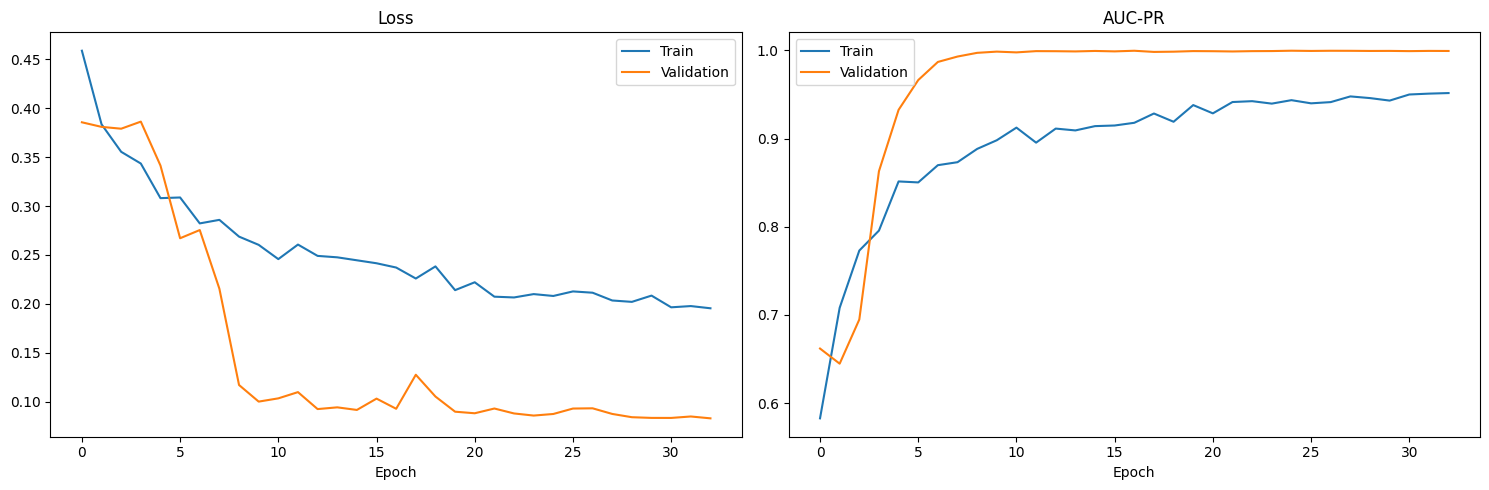

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  # Smaller model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
import datetime
from sklearn.utils import class_weight

# Configuration
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 100
INIT_LR = 3e-5
MIN_LR = 1e-7
CLASS_MODE = 'binary'

# Paths
base_dir = '/content/drive/MyDrive/weapons.v3i.folder'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they don't exist
os.makedirs(base_dir, exist_ok=True)
os.makedirs(os.path.join(base_dir, 'logs'), exist_ok=True)

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators with balanced class sampling
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)

# Calculate class weights
labels = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

# Model Architecture
def build_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )

    # Freeze first 50% of layers
    for layer in base_model.layers[:int(len(base_model.layers)*0.5)]:
        layer.trainable = False

    # Custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='swish', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='swish', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Balanced Binary Crossentropy
def balanced_binary_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    loss = -tf.reduce_mean(0.5 * y_true * tf.math.log(y_pred) +
           0.5 * (1 - y_true) * tf.math.log(1 - y_pred))
    return loss

model = build_model()

# Metrics
metrics = [
    AUC(name='auc', curve='PR'),
    Precision(name='precision'),
    Recall(name='recall'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
]

# Model saving paths
model_save_path = os.path.join(base_dir, 'best_model.keras')
final_model_save_path = os.path.join(base_dir, 'final_model.keras')
training_plot_path = os.path.join(base_dir, 'training_history.png')

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=8, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=MIN_LR, mode='max'),
    ModelCheckpoint(
        model_save_path,
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        save_format='keras'
    ),
    TensorBoard(
        log_dir=os.path.join(base_dir, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
        histogram_freq=1
    )
]

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
    loss=balanced_binary_crossentropy,
    metrics=metrics
)

# Train
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Save the final model after training
model.save(final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

# Evaluation
test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)

results = model.evaluate(test_gen)
print("\nTest Results:")
print(f"AUC-PR: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")
print(f"Accuracy: {results[4]:.4f}")

# Save evaluation results to a text file
eval_results_path = os.path.join(base_dir, 'evaluation_results.txt')
with open(eval_results_path, 'w') as f:
    f.write("Test Results:\n")
    f.write(f"AUC-PR: {results[1]:.4f}\n")
    f.write(f"Precision: {results[2]:.4f}\n")
    f.write(f"Recall: {results[3]:.4f}\n")
    f.write(f"Accuracy: {results[4]:.4f}\n")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # AUC-PR
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train')
    plt.plot(history.history['val_auc'], label='Validation')
    plt.title('AUC-PR')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.savefig(training_plot_path)
    plt.show()

plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


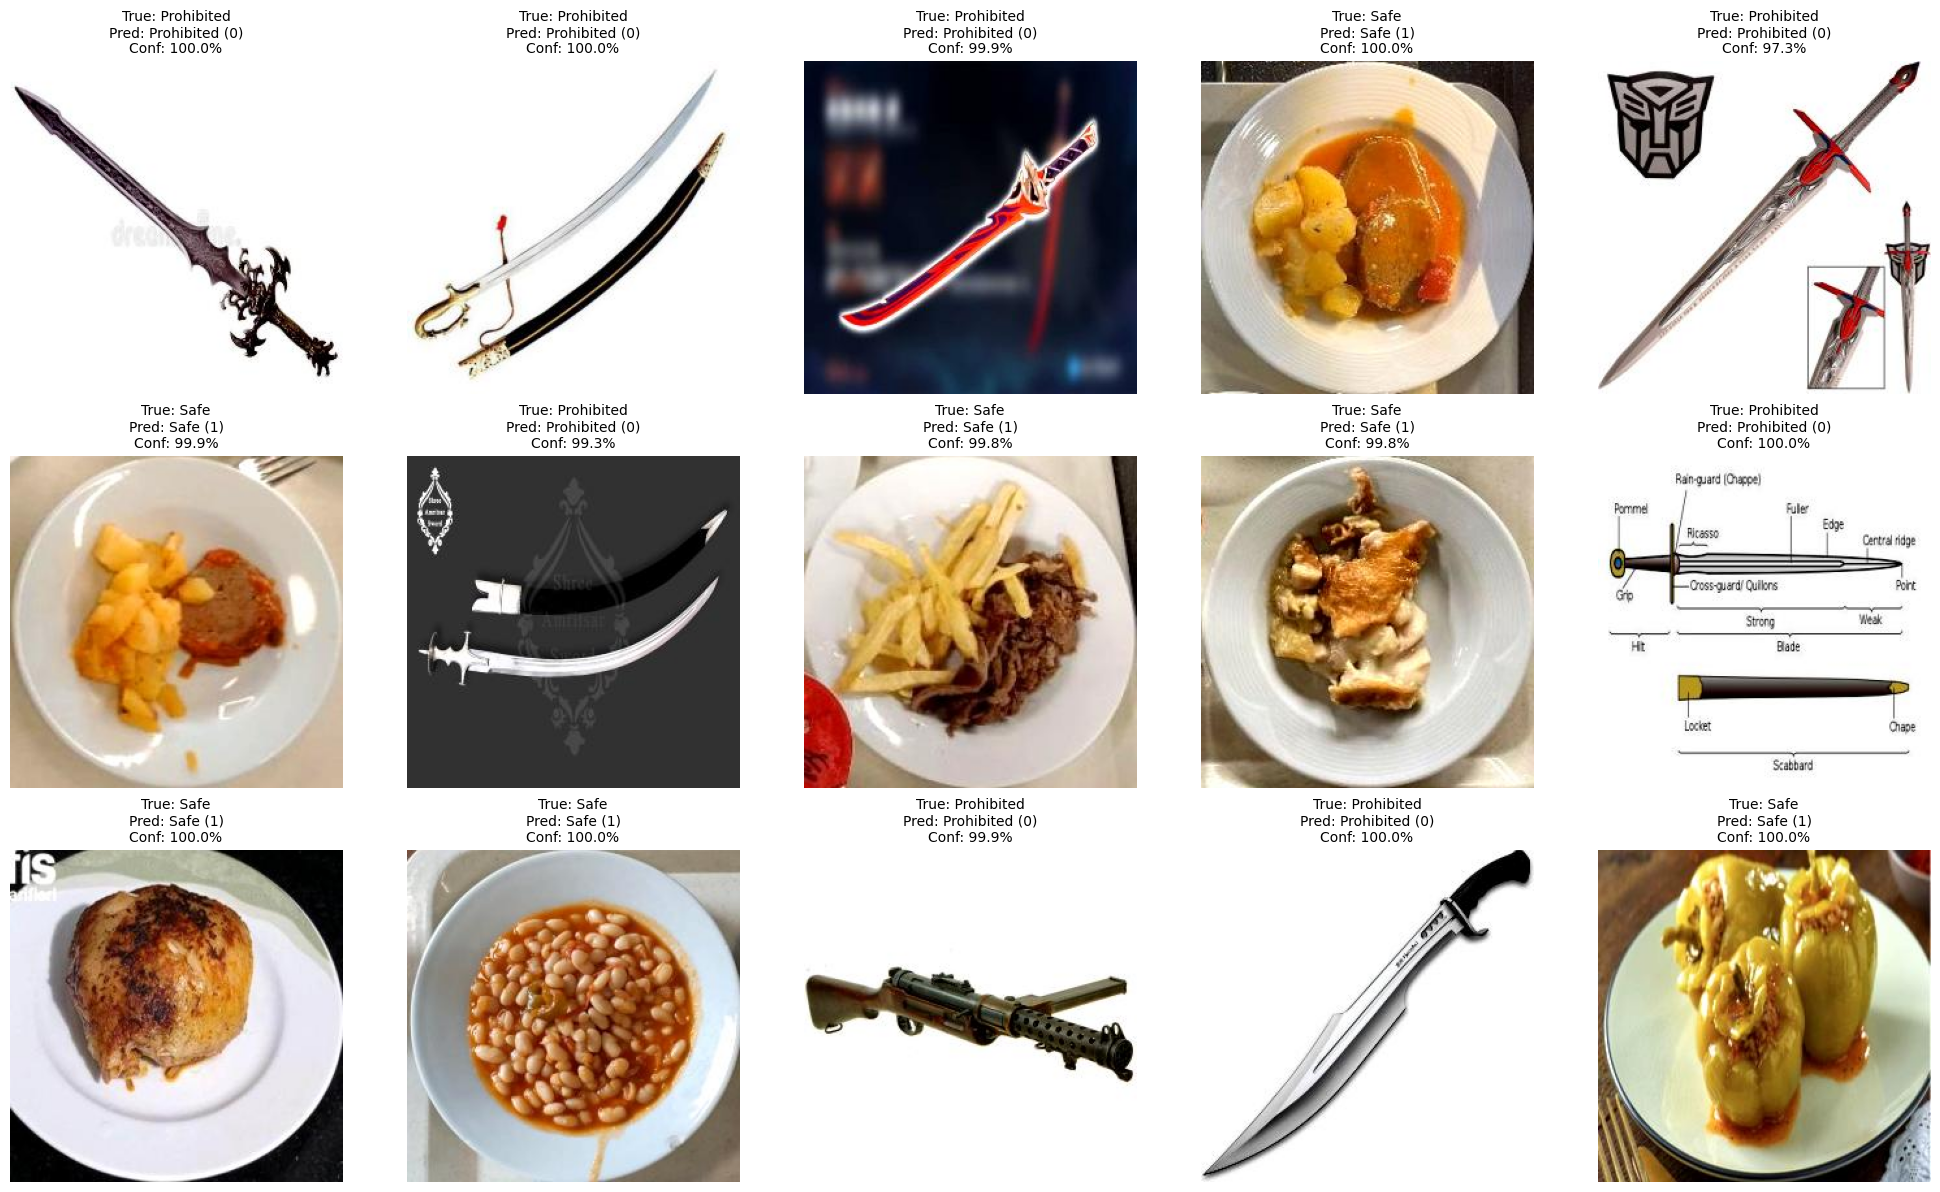

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Configuration
IMG_SIZE = (256, 256)
MODEL_PATH = '/content/drive/MyDrive/weapons.v3i.folder/best_model.keras'
TEST_DIR = '/content/drive/MyDrive/weapons.v3i.folder/test'
NUM_IMAGES = 15  # Number of random images to test

# Load model
try:
    model = load_model(MODEL_PATH)
except:
    from tensorflow.keras.utils import custom_object_scope
    with custom_object_scope({'balanced_binary_crossentropy': lambda y_true, y_pred: y_pred}):
        model = load_model(MODEL_PATH)

# Collect test images
image_paths = []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

selected_images = np.random.choice(image_paths, min(NUM_IMAGES, len(image_paths)), replace=False)

# Determine grid size
cols = 5
rows = (len(selected_images) + cols - 1) // cols

# Plotting
plt.figure(figsize=(4 * cols, 4 * rows))
for i, img_path in enumerate(selected_images, 1):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]
    pred_class = "Safe (1)" if pred > 0.5 else "Prohibited (0)"
    confidence = pred if pred > 0.5 else 1 - pred
    true_class = "Safe" if "safe" in img_path.lower() else "Prohibited"

    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1%}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


## **Below is the code for exxplosive dataset marked as safe and prohibited**

In [ ]:
# Mount Google Drive (run this cell and follow authorization prompt)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Splitting the dataset into test train and valid because roboflow splitting cause the error

Found 1772 images belonging to 2 classes.
Found 379 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5866 - auc: 0.6210 - loss: 0.8486 - val_accuracy: 0.3272 - val_auc: 0.5000 - val_loss: 0.6940 - learning_rate: 1.0000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 723ms/step - accuracy: 0.6620 - auc: 0.7246 - loss: 0.7066 - val_accuracy: 0.5013 - val_auc: 0.5310 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 744ms/step - accuracy: 0.6696 - auc: 0.7311 - loss: 0.7262 - val_accuracy: 0.5013 - val_auc: 0.6576 - val_loss: 0.7020 - learning_rate: 1.0000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 695ms/step - accuracy: 0.6859 - auc: 0.7661 - loss: 0.6422 - val_accuracy: 0.5013 - val_auc: 0.6300 - val_loss: 0.7352 - learning_rate: 1.0000e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 711ms/step - accuracy: 0.7019 - auc: 0.7718 - loss: 0.6310 - val_accuracy: 0.5409 - val_auc: 0.7680 - val_loss: 0.6694 - learning_rate: 1.0000e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 728ms/step - ac

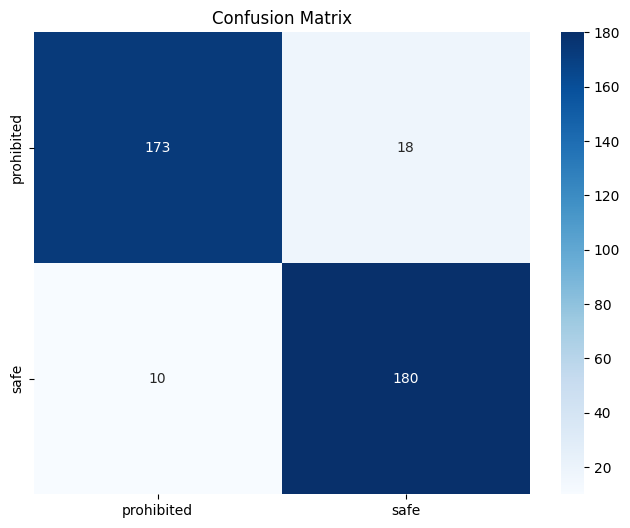

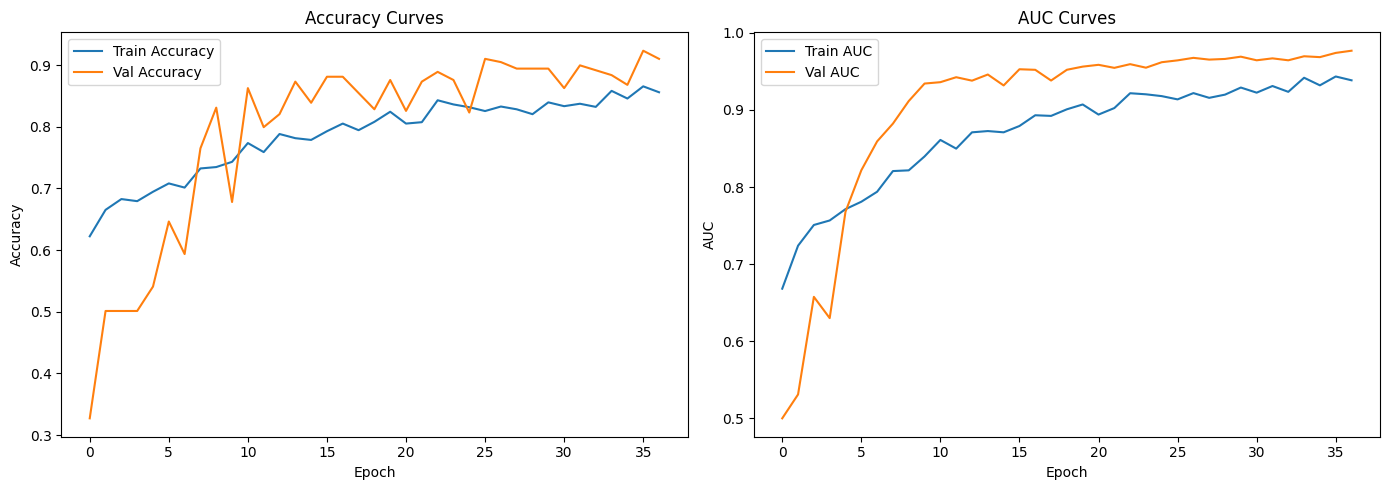

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# ========== CONFIGURATION ==========
base_dir = '/content/drive/MyDrive/explosive.v5i.folder'
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 50

# ========== DATA GENERATORS ==========
def create_generators():
    # Enhanced augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_directory(
        os.path.join(base_dir, 'valid'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    # Calculate class weights for imbalanced data
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    class_weights = dict(enumerate(class_weights))

    return train_gen, val_gen, class_weights

train_gen, val_gen, class_weights = create_generators()

# ========== MODEL ARCHITECTURE ==========
def build_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=IMG_SIZE + (3,)
    )

    # Strategic unfreezing
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    return model

model = build_model()

# ========== CALLBACKS ==========
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        min_delta=0.01,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        mode='max'
    ),
    ModelCheckpoint(
        os.path.join(base_dir, 'best_model.keras'),
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    )
]

# ========== TRAINING ==========
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ========== EVALUATION ==========
def evaluate_model():
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_gen = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )

    model.load_weights(os.path.join(base_dir, 'best_model.keras'))
    results = model.evaluate(test_gen)

    print(f"\nTest Accuracy: {results[1]:.4f}")
    print(f"Test AUC: {results[2]:.4f}")

    # Detailed reports
    y_true = test_gen.classes
    y_pred = (model.predict(test_gen) > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model()

# ========== VISUALIZATION ==========
def plot_training_history(history):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curves')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Testing the model on the test images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 32 test images.


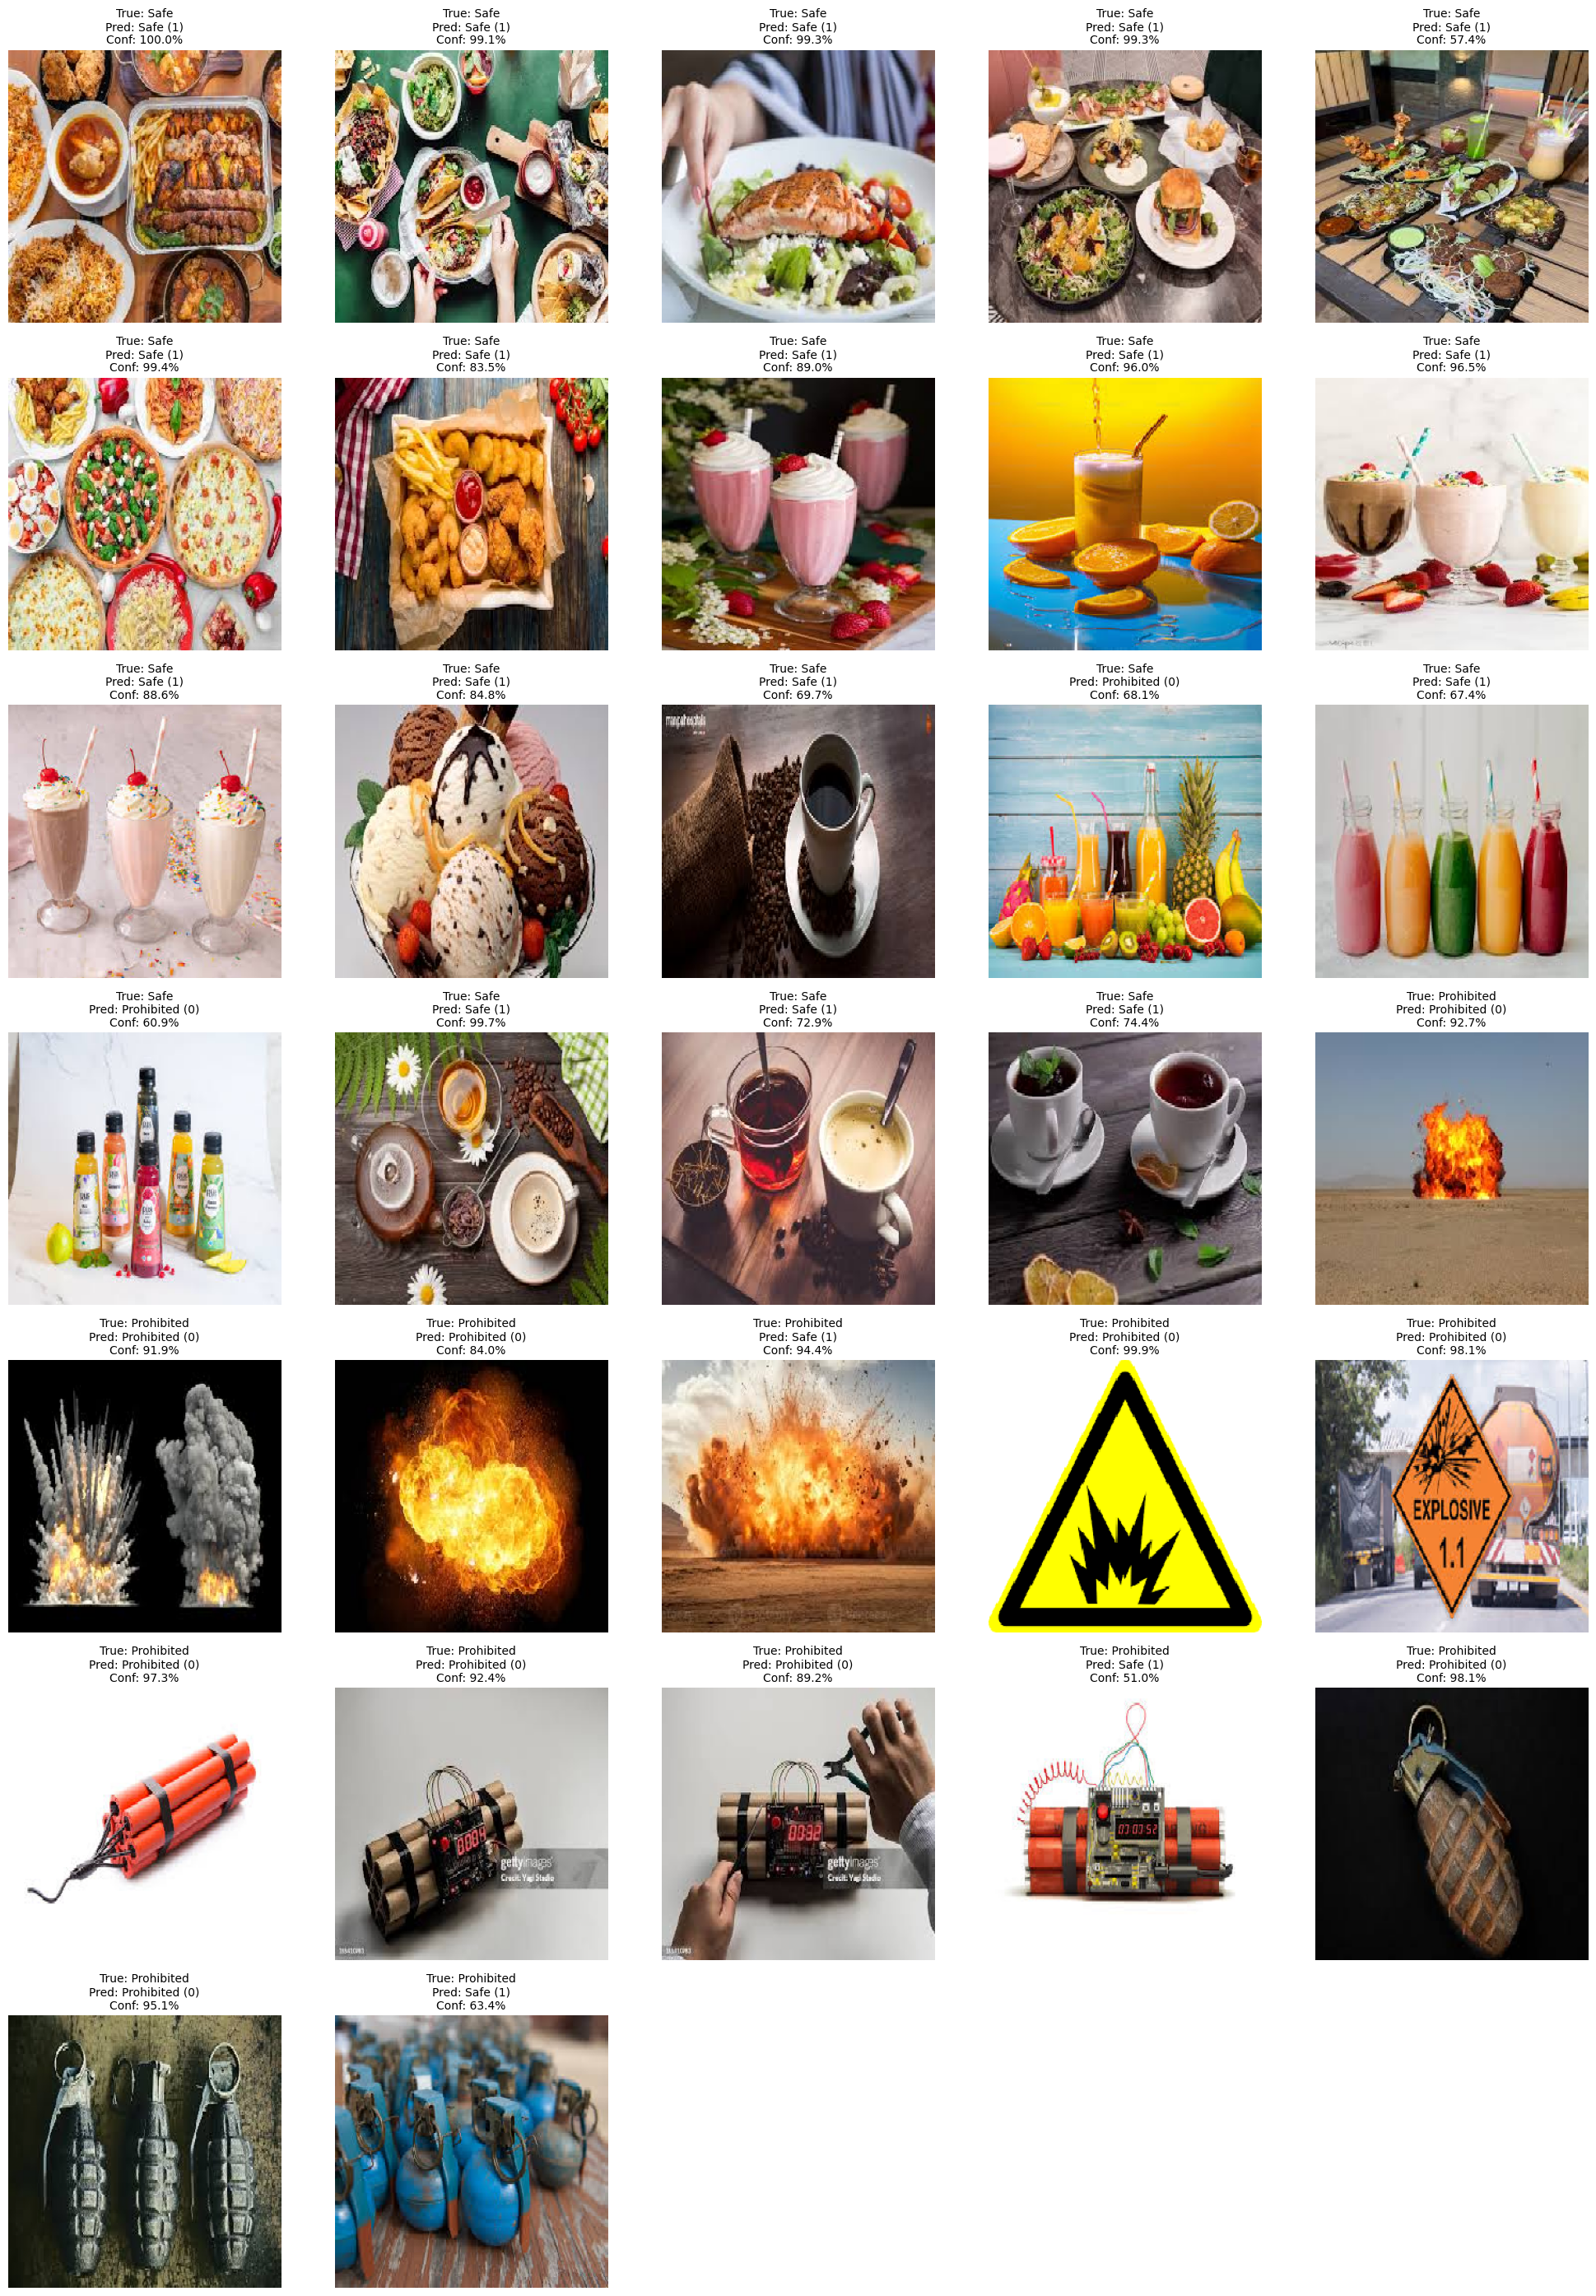

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Config
IMG_SIZE = (256, 256)
TEST_IMG_DIR = '/content/drive/MyDrive/explosive.v5i.folder/test_img'
MODEL_PATH = '/content/drive/MyDrive/explosive.v5i.folder/best_model.keras'
SUPPORTED_FORMATS = ('.png', '.jpg', '.jpeg', '.jfif')

# Load model
try:
    model = load_model(MODEL_PATH)
except:
    from tensorflow.keras.utils import custom_object_scope
    with custom_object_scope({'balanced_binary_crossentropy': lambda y_true, y_pred: y_pred}):
        model = load_model(MODEL_PATH)

# Load test images with auto-labels from folder names
image_paths = []
true_labels = []

for root, dirs, files in os.walk(TEST_IMG_DIR):
    for file in files:
        if file.lower().endswith(SUPPORTED_FORMATS):
            full_path = os.path.join(root, file)
            label_folder = os.path.basename(root).lower()
            if "safe" in label_folder:
                true_labels.append("Safe")
            elif "prohibited" in label_folder:
                true_labels.append("Prohibited")
            else:
                true_labels.append("Unknown")
            image_paths.append(full_path)

print(f"Found {len(image_paths)} test images.")

# Display predictions
cols = 5
rows = (len(image_paths) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for i, img_path in enumerate(image_paths):
    img_name = os.path.basename(img_path)
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array, verbose=0)[0][0]
    pred_class = "Safe (1)" if pred > 0.5 else "Prohibited (0)"
    confidence = pred if pred > 0.5 else 1 - pred

    true_label = true_labels[i]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_class}\nConf: {confidence:.1%}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Now train the model on gore content **

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Found 1116 images belonging to 2 classes.
Found 77 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 431s 11s/step - accuracy: 0.5128 - auc: 0.5340 - loss: 0.9521 - val_accuracy: 0.9610 - val_auc: 0.5000 - val_loss: 0.4876 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 653ms/step - accuracy: 0.5867 - auc: 0.6505 - loss: 0.7965 - val_accuracy: 0.9610 - val_auc: 0.5000 - val_loss: 0.4894 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 725ms/step - accuracy: 0.5937 - auc: 0.6715 - loss: 0.7930 - val_accuracy: 0.9610 - val_auc: 0.5270 - val_loss: 0.4738 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 695ms/step - accuracy: 0.5983 - auc: 0.7030 - loss: 0.7469 - val_accuracy: 0.9610 - val_auc: 0.5000 - val_loss: 0.3460 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 699ms/step - accuracy: 0.6427 - auc: 0.7462 - loss: 0.6626 - val_accuracy: 0.9610 - val_auc: 0.4730 - val_loss: 0.2577 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 685ms/step - a

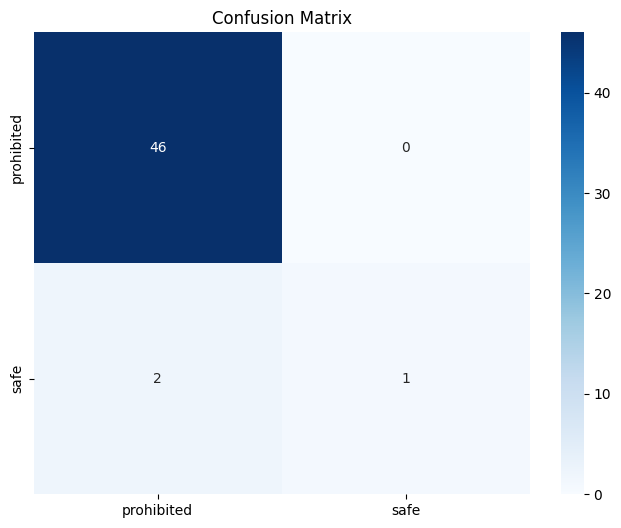

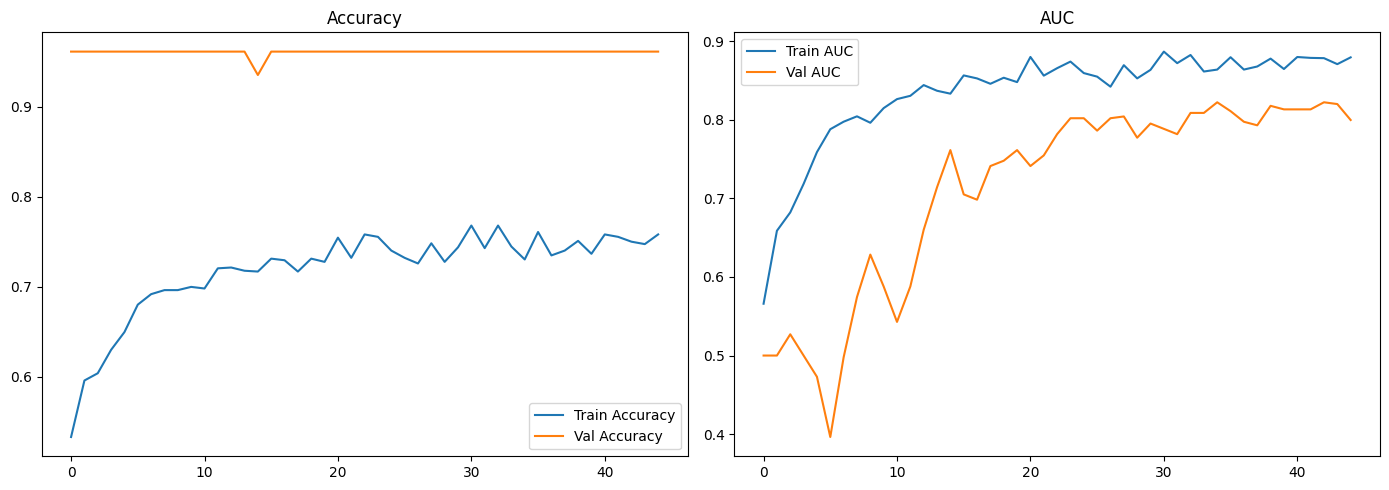

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# ====== CONFIG ======
base_dir = '/content/drive/MyDrive/gore_content.v2i.folder'  # UPDATE if needed
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 50

# ====== DATA GENERATORS ======
def create_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(base_dir, 'valid'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    return train_gen, val_gen, dict(enumerate(class_weights))

train_gen, val_gen, class_weights = create_generators()

# ====== MODEL ARCHITECTURE ======
def build_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

model = build_model()

# ====== CALLBACKS ======
callbacks = [
    EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, mode='max'),
    ModelCheckpoint(os.path.join(base_dir, 'best_gore_model.keras'), monitor='val_auc', save_best_only=True, mode='max')
]

# ====== TRAINING ======
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ====== EVALUATION ======
def evaluate_model():
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_gen = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )

    model.load_weights(os.path.join(base_dir, 'best_gore_model.keras'))
    results = model.evaluate(test_gen)
    print(f"\nTest Accuracy: {results[1]:.4f}")
    print(f"Test AUC: {results[2]:.4f}")

    y_true = test_gen.classes
    y_pred = (model.predict(test_gen) > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model()

# ====== PLOTTING ======
def plot_training_history(history):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)
